In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

response = requests.get(url="https://rupaulsdragrace.fandom.com/wiki/Raven",)
soup = BeautifulSoup(response.content, 'html.parser')

title = soup.find(id="firstHeading")
print(title.string)

Raven


### Get a list of RPDR Contestants from all Seasons

There's a nice table on wikipedia that lists out all the queens from all seasons. This is a great starting point.

In [89]:
response = requests.get(url="https://en.wikipedia.org/wiki/List_of_RuPaul%27s_Drag_Race_contestants",)
soup = BeautifulSoup(response.content, 'html.parser')

#wikitable sortable jquery-tablesorter

table = soup.find("table", {"class":"wikitable sortable"})
df = pd.read_html(str(table))[0]
df

,Season,Contestant,Age,Hometown,Outcome
0,Season 1,BeBe Zahara Benet,28,"Minneapolis, Minnesota [a]",Winner
1,Season 1,Nina Flowers,34,"Denver, Colorado [b]",Runner-up
2,Season 1,Rebecca Glasscock,26,"Fort Lauderdale, Florida",3rd
3,Season 1,Shannel,26,"Las Vegas, Nevada",4th
4,Season 1,Ongina,26,"Los Angeles, California",5th
...,...,...,...,...,...
165,Season 13,Rosé,31,"New York City, New York",TBA
166,Season 13,Symone,25,"Los Angeles, California",TBA
167,Season 13,Tamisha Iman,43,"Atlanta, Georgia",TBA
168,Season 13,Tina Burner,39,"New York City, New York",TBA


Contestants name is stored in a column within our new table. We just want contestant name for now, time to convert this into a list.

In [90]:
contestants = df["Contestant"].tolist()

Some contestants have appeared on more than one season (we have dupes!). Create a for loop to drop duplicate names. The RPDR wikipedia also breaks out spaces with "_" .

In [91]:
queens = []
for i in contestants:
    index = i.find('[') 
    if index != -1:
        queen= i[:index]
    else:
        queen = i
    queen_link = queen.replace(' ', '_')
    if queen_link not in queens: 
        queens.append(queen_link)
        
queens = sorted(queens)


In [92]:
base = 'https://rupaulsdragrace.fandom.com/wiki/'

data_points = ["Real Name","Ethnicity","Current City","Hometown","birth year"]

d = []
for queen in queens:
    response = requests.get(url=base+queen)
    soup = BeautifulSoup(response.content, 'html.parser')
    for i in data_points:
        try:
            field = i 
            data = str(soup.find("div", {"data-source": field}).find("div", {"class": "pi-data-value pi-font"}))
            start = data.find(">")+1
            data = data[start:]
            data = data[:-6]
            d.append({'queen': queen, 
                  'field': field.upper(), 
                  'data':data
         })
        except:
            pass

        df_info = pd.DataFrame(d)

        
df_info

,queen,field,data
0,A'keria_C._Davenport,REAL NAME,Gregory D'Wayne
1,A'keria_C._Davenport,ETHNICITY,African-American
2,A'keria_C._Davenport,CURRENT CITY,"Houston, Texas"
3,A'keria_C._Davenport,HOMETOWN,"Dallas, Texas"
4,A'keria_C._Davenport,BIRTH YEAR,"March 1, 1988"
...,...,...,...
676,Yuhua_Hamasaki,BIRTH YEAR,"March 1, 1990"
677,Yvie_Oddly,REAL NAME,Jovan Bridges
678,Yvie_Oddly,ETHNICITY,African-Native American
679,Yvie_Oddly,CURRENT CITY,"Denver, Colorado"


In [382]:
df2 = df_info.pivot_table(index=['queen'],
                      columns=['field'], 
                      values=['data'],
                      aggfunc=lambda x: ' '.join(str(v) for v in x))

In [11]:
base = 'https://rupaulsdragrace.fandom.com/wiki/'

qdf = pd.DataFrame() 
for queen in queens:
    try:
        response = requests.get(url=base+queen)
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find("table", {"class":"wikitable"})
        df = pd.read_html(str(table))[0]
        df = df.iloc[:, : 2]
        df['season'] = df.columns[1]
        df.columns = ["detail", "info","season"]
        df['queen'] = queen
    except:
        pass
    qdf = pd.concat([qdf, df])

    
qdf
#qdf[qdf.queen == 'Yuhua_Hamasaki']

,detail,info,season,queen
0,Ranking:,3rd/4th Place,Season 11,A'keria_C._Davenport
1,Mini-Challenges Won:,1 (Ep. 6),Season 11,A'keria_C._Davenport
2,Maxi Challenges Won:,"2 (Eps. 6, 9)",Season 11,A'keria_C._Davenport
3,Times Placed High:,"3 (Eps. 1, 11, 12)",Season 11,A'keria_C._Davenport
4,Times in Bottom:,"2 (Eps. 3, 7)",Season 11,A'keria_C._Davenport
...,...,...,...,...
3,Times Placed Low:,1 (Ep. 11),Season 11,Yvie_Oddly
4,Times in Bottom Two:,1 (Ep. 8),Season 11,Yvie_Oddly
5,Mini Challenges Won:,0,Season 11,Yvie_Oddly
6,Times as Team Captain:,0,Season 11,Yvie_Oddly


In [12]:
qdf = qdf.drop_duplicates()

In [13]:
qdf = qdf[qdf.season != 'Season 13']
qdf['detail'] = qdf['detail'].str.upper() 
qdf['detail'] = qdf['detail'].str.replace(':', '')
qdf['detail'] = qdf['detail'].str.replace('-', ' ')
qdf['detail'] = qdf['detail'].str.replace('2', 'TWO')
qdf['detail'] = qdf['detail'].str.replace('MAIN', 'MAXI')
qdf['detail'] = qdf['detail'].str.replace('TIMES IN BOTTOM TWO', 'TIMES IN BOTTOM')
qdf.detail.unique()

array(['RANKING', 'MINI CHALLENGES WON', 'MAXI CHALLENGES WON',
       'TIMES PLACED HIGH', 'TIMES IN BOTTOM', 'TIMES AS TEAM CAPTAIN',
       'TIMES PLACED LOW', 'EPISODE ELIMINATED', 'TOP TWO PLACEMENTS'],
      dtype=object)

In [15]:
df1 = qdf.pivot_table(index=['queen','season'],
                      columns=['detail'], 
                      values=['info'],
                      aggfunc=lambda x: ' '.join(str(v) for v in x))

df1.columns = [col[1] for col in df1.columns]

df1.sample(20)

,,EPISODE ELIMINATED,MAXI CHALLENGES WON,MINI CHALLENGES WON,RANKING,TIMES AS TEAM CAPTAIN,TIMES IN BOTTOM,TIMES PLACED HIGH,TIMES PLACED LOW,TOP TWO PLACEMENTS
queen,season,,,,,,,,,
Sherry_Pie,Season 12,nan,"2 (Ep. 3, 5)",0,4th(Disqualified),0,0,NaN,NaN,1 (Ep. 1)
Sharon_Needles,Season 4,nan,"4 (Eps. 1, 3, 9, 11)",0,1st (Winner),0,1 (Ep. 8),"3 (Eps. 2, 5, 7)",1 (Ep. 10),NaN
Brita,Season 12,Episode 7,0,0,9th Place,0,"3 (Eps. 4, 6, 7)",1 (Ep. 1),1 (Ep. 5),NaN
Jinkx_Monsoon,Season 5,nan,"2 (Eps. 5, 9)",1 (Ep. 4),1st Place,1 (Ep. 4),1 (Ep. 11),"7 (Eps. 2, 3, 4, 6, 7, 8, 10)",0,NaN
Raven,Season 2,Episode 11,"2 (Eps. 7, 8)","3 (Eps. 1, 4, 5)",2nd Place(Runner-Up),0,"2 (Eps. 2, 3)","3 (Eps. 5, 6, 9)",0,NaN
Mystique_Summers_Madison,Season 2,Episode 3,0,1 (Ep. 3),10th Place,1 (Ep. 3),1 (Ep. 3),1 (Ep. 2),1 (Ep. 1),NaN
Willam,Season 4,Episode 8,"2 (Eps. 6, 8)","3 (Eps. 2, 4, 6)",7th Place,"2 (Eps. 2, 4)",1 (Ep. 7),"2 (Eps. 4, 5)",0,NaN
Tyra_Sanchez,Season 2,nan,"3 (Eps. 3, 5, 9)",1 (Ep. 9),1st (Winner),0,0,"4 (Eps. 1, 2, 7, 8)",1 (Ep. 6),NaN
Mrs._Kasha_Davis,Season 7,Episode 5,0,1 (Ep. 5),11th Place,0,1 (Ep. 5),"2 (Eps. 2, 3)",0,NaN


In [78]:
import requests
import pandas as pd
from bs4 import BeautifulSoup


seasons = list(range(1,13))

season_url_base = 'https://rupaulsdragrace.fandom.com/wiki/RuPaul%27s_Drag_Race_(Season_'

season_df = pd.DataFrame() 
season_dict = pd.DataFrame()
for season in seasons:
    try:
        response = requests.get(url=season_url_base+str(season)+")")
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find("table", {"class":"wikitable"})
        df = pd.read_html(str(table))[0]
        #create data dictionary dataframe
        parent_column = [col[0] for col in df.columns]
        sub_column = [col[1] for col in df.columns]
        sub_season_dict = pd.DataFrame({'parent_column':parent_column, 'sub_column':sub_column})
        sub_season_dict['SEASON']=season
        #clean data for main dataframe (season_df)
        df.columns = [col[0] for col in df.columns]
        df['SEASON'] = season
        slist = df.columns.to_list()
        df.columns= df.columns.str.strip().str.upper()
        df.columns = df.columns.str.replace(' ', '')
        df['SEASON_EPISODES'] = len([i for i in slist if "EP." in i]) 
    except:
        pass
    season_df = pd.concat([season_df, df])
    season_dict = pd.concat([season_dict, sub_season_dict])

season_df

,RANK,CONTESTANT,PHOTO,REALNAME,AGE,CURRENTCITY,EP.1,EP.2,EP.3,EP.4,...,SEASON_EPISODES,EP.10,EP.11,EP.12,EP.13,EP.14,EP.15,EP.16,NAME,HOMETOWN
0,1st(Winner),BeBe Zahara Benet,NaN,Nea Marshall Kudi Ngwa,28,"Minneapolis, MN",SAFE,SAFE,WIN,HIGH,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2nd(Miss Congeniality),Nina Flowers,NaN,Jorge Flores,34,"Bayamón, PR",WIN,HIGHTEAM,HIGH,HIGH,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3rd,Rebecca Glasscock,NaN,Javier Rivera,26,"Ft. Lauderdale, FL",LOW,HIGHTEAM,HIGH,BTM2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4th,Shannel,NaN,Bryan Watkins,29,"Las Vegas, NV",SAFE,HIGHTEAM,BTM2,LOW,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5th,Ongina,NaN,Ryan Ong Palao,26,"Los Angeles, CA",HIGH,WINTeamCaptain,HIGH,WIN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,9th,Brita(Group 1),NaN,JesseHavea,34,"New York, NY",HIGH,NaN,SAFE,BTM2,...,0,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,NaN,NaN
9,10th,AidenZhane(Group 2),NaN,DevinLewis,29,"Acworth,GA",NaN,HIGH,SAFETeamCaptain,LOW,...,0,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,NaN,NaN
10,11th,NickyDoll(Group 1),NaN,KarlSanchez,28,"New York, NY",LOW,NaN,BTM2,HIGH,...,0,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,NaN,NaN
11,12th,RockM.Sakura(Group 2),NaN,BryanStevenBradford,28,"SanFrancisco,CA",NaN,LOW,SAFE,ELIM,...,0,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,NaN,NaN


In [79]:
#drop columns
season_df = season_df.drop(columns=['PHOTO','SEASON_EPISODES'])

#merge name and real name columns
season_df['REAL_NAME']= season_df.NAME.combine_first(season_df.REALNAME)
season_df = season_df.drop(columns=['REALNAME','NAME'])

#merge current city and hometown city columns
season_df['CITY_STATE']= season_df.HOMETOWN.combine_first(season_df.CURRENTCITY)
season_df = season_df.drop(columns=['CURRENTCITY','HOMETOWN'])

#Remove Groups from contestant names
season_df['CONTESTANT'] = season_df['CONTESTANT'].str.replace('(Group 1)', '')
season_df['CONTESTANT'] = season_df['CONTESTANT'].str.replace('(Group 2)', '')
season_df['CONTESTANT'] = season_df['CONTESTANT'].str.replace(r"\(.*\)","")

season_df

,RANK,CONTESTANT,AGE,EP.1,EP.2,EP.3,EP.4,EP.5,EP.6,EP.7,...,SEASON,EP.10,EP.11,EP.12,EP.13,EP.14,EP.15,EP.16,REAL_NAME,CITY_STATE
0,1st(Winner),BeBe Zahara Benet,28,SAFE,SAFE,WIN,HIGH,BTM2,WIN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nea Marshall Kudi Ngwa,"Minneapolis, MN"
1,2nd(Miss Congeniality),Nina Flowers,34,WIN,HIGHTEAM,HIGH,HIGH,LOW,HIGHMini Chall.Winner,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jorge Flores,"Bayamón, PR"
2,3rd,Rebecca Glasscock,26,LOW,HIGHTEAM,HIGH,BTM2,WINMini Chall.Winner,BTM2,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Javier Rivera,"Ft. Lauderdale, FL"
3,4th,Shannel,29,SAFE,HIGHTEAM,BTM2,LOW,HIGH,ELIM,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bryan Watkins,"Las Vegas, NV"
4,5th,Ongina,26,HIGH,WINTeamCaptain,HIGH,WIN,ELIM,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ryan Ong Palao,"Los Angeles, CA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,9th,Brita,34,HIGH,NaN,SAFE,BTM2,LOW,BTM2,ELIM,...,12,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,JesseHavea,"New York, NY"
9,10th,AidenZhane,29,NaN,HIGH,SAFETeamCaptain,LOW,HIGH,ELIM,NaN,...,12,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,DevinLewis,"Acworth,GA"
10,11th,NickyDoll,28,LOW,NaN,BTM2,HIGH,ELIM,NaN,NaN,...,12,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,KarlSanchez,"New York, NY"
11,12th,RockM.Sakura,28,NaN,LOW,SAFE,ELIM,NaN,NaN,NaN,...,12,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,BryanStevenBradford,"SanFrancisco,CA"


In [80]:
season_df = season_df[['SEASON','RANK','CONTESTANT','REAL_NAME','CITY_STATE','AGE','EP.1','EP.2','EP.3','EP.4','EP.5','EP.6',
          'EP.7','EP.8','EP.9','EP.10','EP.11','EP.12','EP.13','EP.14','EP.15','EP.16']]

season_df

,SEASON,RANK,CONTESTANT,REAL_NAME,CITY_STATE,AGE,EP.1,EP.2,EP.3,EP.4,...,EP.7,EP.8,EP.9,EP.10,EP.11,EP.12,EP.13,EP.14,EP.15,EP.16
0,1,1st(Winner),BeBe Zahara Benet,Nea Marshall Kudi Ngwa,"Minneapolis, MN",28,SAFE,SAFE,WIN,HIGH,...,NaN,WINNER,RTRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2nd(Miss Congeniality),Nina Flowers,Jorge Flores,"Bayamón, PR",34,WIN,HIGHTEAM,HIGH,HIGH,...,NaN,RUNNERUP,MISSCON,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3rd,Rebecca Glasscock,Javier Rivera,"Ft. Lauderdale, FL",26,LOW,HIGHTEAM,HIGH,BTM2,...,NaN,ELIM,RTRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4th,Shannel,Bryan Watkins,"Las Vegas, NV",29,SAFE,HIGHTEAM,BTM2,LOW,...,NaN,NaN,RTRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5th,Ongina,Ryan Ong Palao,"Los Angeles, CA",26,HIGH,WINTeamCaptain,HIGH,WIN,...,NaN,NaN,RTRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,12,9th,Brita,JesseHavea,"New York, NY",34,HIGH,NaN,SAFE,BTM2,...,ELIM,NaN,NaN,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN
9,12,10th,AidenZhane,DevinLewis,"Acworth,GA",29,NaN,HIGH,SAFETeamCaptain,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN
10,12,11th,NickyDoll,KarlSanchez,"New York, NY",28,LOW,NaN,BTM2,HIGH,...,NaN,NaN,NaN,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN
11,12,12th,RockM.Sakura,BryanStevenBradford,"SanFrancisco,CA",28,NaN,LOW,SAFE,ELIM,...,NaN,NaN,NaN,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN


In [ ]:
re.sub('([A-Z])', r' \1', 'Hello There')

for row in test.itertuples():
    city_state = row.CITY
    comma_index = row.CITY.index(',')
    city = city_state[0:comma_index]
    state = city_state[comma_index+1:].strip()
    upper_count = len(re.findall(r'[A-Z]',city))
    space_count = city.count(' ')
    if upper_count - 1 == space_count:
        print(city.strip())
    else:
        print(re.sub('([A-Z])', r' \1', city).strip())
    #print(city.strip())

In [81]:
season_dict.columns = ["EPISODE", "EPISODE_TYPE","SEASON"]
season_dict['EPISODE_TYPE'] = season_dict['EPISODE_TYPE'].str.upper() 
season_dict['EPISODE_TYPE'] = season_dict['EPISODE_TYPE'].str.replace(' ', '')
season_dict['EPISODE'] = season_dict['EPISODE'].str.upper() 
season_dict['EPISODE'] = season_dict['EPISODE'].str.replace(' ', '')
makeover = season_dict[season_dict.EPISODE_TYPE == 'MAKEOVER']
reunion = season_dict[season_dict.EPISODE_TYPE == 'REUNION']
snatchgame = season_dict[season_dict.EPISODE_TYPE == 'SNATCHGAME']

In [82]:

total_df = pd.merge(season_df, makeover, how='left', on='SEASON')
total_df.rename(columns={'EPISODE':'MAKEOVER_EPISODE'}, inplace=True)
total_df = total_df.drop(columns=['EPISODE_TYPE'])

total_df = pd.merge(total_df, snatchgame, how='left', on='SEASON')
total_df.rename(columns={'EPISODE':'SNATCHGAME_EPISODE'}, inplace=True)
total_df = total_df.drop(columns=['EPISODE_TYPE'])

total_df = pd.merge(total_df, reunion, how='left', on='SEASON')
total_df.rename(columns={'EPISODE':'REUNION_EPISODE'}, inplace=True)
total_df = total_df.drop(columns=['EPISODE_TYPE'])



total_df

,SEASON,RANK,CONTESTANT,REAL_NAME,CITY_STATE,AGE,EP.1,EP.2,EP.3,EP.4,...,EP.10,EP.11,EP.12,EP.13,EP.14,EP.15,EP.16,MAKEOVER_EPISODE,SNATCHGAME_EPISODE,REUNION_EPISODE
0,1,1st(Winner),BeBe Zahara Benet,Nea Marshall Kudi Ngwa,"Minneapolis, MN",28,SAFE,SAFE,WIN,HIGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9
1,1,2nd(Miss Congeniality),Nina Flowers,Jorge Flores,"Bayamón, PR",34,WIN,HIGHTEAM,HIGH,HIGH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9
2,1,3rd,Rebecca Glasscock,Javier Rivera,"Ft. Lauderdale, FL",26,LOW,HIGHTEAM,HIGH,BTM2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9
3,1,4th,Shannel,Bryan Watkins,"Las Vegas, NV",29,SAFE,HIGHTEAM,BTM2,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9
4,1,5th,Ongina,Ryan Ong Palao,"Los Angeles, CA",26,HIGH,WINTeamCaptain,HIGH,WIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,12,9th,Brita,JesseHavea,"New York, NY",34,HIGH,NaN,SAFE,BTM2,...,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13
153,12,10th,AidenZhane,DevinLewis,"Acworth,GA",29,NaN,HIGH,SAFETeamCaptain,LOW,...,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13
154,12,11th,NickyDoll,KarlSanchez,"New York, NY",28,LOW,NaN,BTM2,HIGH,...,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13
155,12,12th,RockM.Sakura,BryanStevenBradford,"SanFrancisco,CA",28,NaN,LOW,SAFE,ELIM,...,NaN,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13


In [84]:
import numpy as np
total_df['MAKEOVER_RANK'] = total_df.lookup(total_df.index, total_df['MAKEOVER_EPISODE'])

#total_df['SNATCHGAME_RANK'] = total_df.lookup(total_df.index, total_df['SNATCHGAME_EPISODE'])
total_df

,SEASON,RANK,CONTESTANT,REAL_NAME,CITY_STATE,AGE,EP.1,EP.2,EP.3,EP.4,...,EP.11,EP.12,EP.13,EP.14,EP.15,EP.16,MAKEOVER_EPISODE,SNATCHGAME_EPISODE,REUNION_EPISODE,MAKEOVER_RANK
0,1,1st(Winner),BeBe Zahara Benet,Nea Marshall Kudi Ngwa,"Minneapolis, MN",28,SAFE,SAFE,WIN,HIGH,...,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9,BTM2
1,1,2nd(Miss Congeniality),Nina Flowers,Jorge Flores,"Bayamón, PR",34,WIN,HIGHTEAM,HIGH,HIGH,...,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9,LOW
2,1,3rd,Rebecca Glasscock,Javier Rivera,"Ft. Lauderdale, FL",26,LOW,HIGHTEAM,HIGH,BTM2,...,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9,WINMini Chall.Winner
3,1,4th,Shannel,Bryan Watkins,"Las Vegas, NV",29,SAFE,HIGHTEAM,BTM2,LOW,...,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9,HIGH
4,1,5th,Ongina,Ryan Ong Palao,"Los Angeles, CA",26,HIGH,WINTeamCaptain,HIGH,WIN,...,NaN,NaN,NaN,NaN,NaN,NaN,EP.5,NaN,EP.9,ELIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,12,9th,Brita,JesseHavea,"New York, NY",34,HIGH,NaN,SAFE,BTM2,...,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13,NaN
153,12,10th,AidenZhane,DevinLewis,"Acworth,GA",29,NaN,HIGH,SAFETeamCaptain,LOW,...,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13,NaN
154,12,11th,NickyDoll,KarlSanchez,"New York, NY",28,LOW,NaN,BTM2,HIGH,...,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13,NaN
155,12,12th,RockM.Sakura,BryanStevenBradford,"SanFrancisco,CA",28,NaN,LOW,SAFE,ELIM,...,NaN,NaN,RTRN,RTRN,NaN,NaN,EP.10,EP.6,EP.13,NaN


In [72]:
#0 = Nan, 1= ELIM, 2 = BTM2 , 3= SAFE, 4 = HIGH, 5 = WIN

In [85]:
import re
encoded_df = total_df
encoded_df = encoded_df.fillna(0)
encoded_df['MISS_CONGENIALITY'] = np.where(encoded_df['RANK'].str.contains("Cong", case=False, na=False), 1, 0)
encoded_df['WINNER'] = np.where(encoded_df['RANK'].str.contains("Winner", case=False, na=False), 1, 0)
encoded_df.replace(re.compile('.*WIN.*'), 6, inplace=True)
encoded_df.replace(re.compile('.*HIGH.*'), 5, inplace=True)
encoded_df.replace(re.compile('.*TOP.*'), 5, inplace=True)
encoded_df.replace(re.compile('.*RUNNER.*'), 5, inplace=True)
encoded_df.replace(re.compile('.*SAFE.*'), 4, inplace=True)
encoded_df.replace(re.compile('.*LOW.*'), 3, inplace=True)
encoded_df.replace(re.compile('.*BTM.*'), 2, inplace=True)
encoded_df.replace(re.compile('.*ELIM.*'), 1, inplace=True)
encoded_df.replace(re.compile('.*RTRN.*'), 1, inplace=True)
encoded_df.replace(re.compile('.*OUT.*'), 0, inplace=True)
encoded_df

episodes = ['EP.1', 'EP.2','EP.3','EP.4','EP.5','EP.6','EP.7','EP.8','EP.9','EP.10','EP.11','EP.12','EP.13']

encoded_df['NUMBER_WINS'] = (encoded_df[episodes] == 6).sum(axis=1)
encoded_df['NUMBER_HIGHS'] = (encoded_df[episodes] == 5).sum(axis=1)
encoded_df['NUMBER_SAFES'] = (encoded_df[episodes] == 4).sum(axis=1)
encoded_df['NUMBER_LOWS'] = (encoded_df[episodes] == 3).sum(axis=1)
encoded_df['NUMBER_BOTTOMS'] = (encoded_df[episodes] == 2).sum(axis=1)
encoded_df['NUMBER_ELIMS'] = (encoded_df[episodes] == 1).sum(axis=1)
encoded_df['NUMBER_APPEARENCES'] = (encoded_df[episodes] != 0).sum(axis=1)

encoded_df['PERC_WIN_APP'] = encoded_df['NUMBER_WINS']/encoded_df['NUMBER_APPEARENCES']
encoded_df['PERC_HIGH_APP'] = encoded_df['NUMBER_HIGHS']/encoded_df['NUMBER_APPEARENCES']
encoded_df['PERC_SAFE_APP'] = encoded_df['NUMBER_SAFES']/encoded_df['NUMBER_APPEARENCES']
encoded_df['PERC_LOW_APP'] = encoded_df['NUMBER_LOWS']/encoded_df['NUMBER_APPEARENCES']
encoded_df['PERC_BTM_APP'] = encoded_df['NUMBER_BOTTOMS']/encoded_df['NUMBER_APPEARENCES']

encoded_df['TOTAL_POINTS'] = encoded_df.NUMBER_WINS * 6 + encoded_df.NUMBER_HIGHS * 5 + encoded_df.NUMBER_SAFES *3 + encoded_df.NUMBER_LOWS * 3 + encoded_df.NUMBER_BOTTOMS *2 + encoded_df.NUMBER_ELIMS * 1


encoded_df['PERC_POINTS_APP'] = encoded_df.TOTAL_POINTS / (encoded_df.NUMBER_APPEARENCES * 6)

encoded_df


,SEASON,RANK,CONTESTANT,REAL_NAME,CITY_STATE,AGE,EP.1,EP.2,EP.3,EP.4,...,NUMBER_BOTTOMS,NUMBER_ELIMS,NUMBER_APPEARENCES,PERC_WIN_APP,PERC_HIGH_APP,PERC_SAFE_APP,PERC_LOW_APP,PERC_BTM_APP,TOTAL_POINTS,PERC_POINTS_APP
0,1,1st(Winner),BeBe Zahara Benet,Nea Marshall Kudi Ngwa,"Minneapolis, MN",28,4,4,6,5,...,1,1,8,0.375000,0.125000,0.250000,0.000000,0.125000,32,0.666667
1,1,2nd(Miss Congeniality),Nina Flowers,Jorge Flores,"Bayamón, PR",34,6,5,5,5,...,0,0,8,0.125000,0.625000,0.000000,0.125000,0.000000,34,0.708333
2,1,3rd,Rebecca Glasscock,Javier Rivera,"Ft. Lauderdale, FL",26,3,5,5,2,...,2,2,8,0.125000,0.250000,0.000000,0.125000,0.250000,25,0.520833
3,1,4th,Shannel,Bryan Watkins,"Las Vegas, NV",29,4,5,2,3,...,1,2,7,0.000000,0.285714,0.142857,0.142857,0.142857,20,0.476190
4,1,5th,Ongina,Ryan Ong Palao,"Los Angeles, CA",26,5,6,5,6,...,0,2,6,0.333333,0.333333,0.000000,0.000000,0.000000,24,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,12,9th,Brita,JesseHavea,"New York, NY",34,5,0,4,2,...,2,2,7,0.000000,0.142857,0.142857,0.142857,0.285714,17,0.404762
153,12,10th,AidenZhane,DevinLewis,"Acworth,GA",29,0,5,4,3,...,0,2,6,0.000000,0.333333,0.166667,0.166667,0.000000,18,0.500000
154,12,11th,NickyDoll,KarlSanchez,"New York, NY",28,3,0,2,5,...,1,2,5,0.000000,0.200000,0.000000,0.200000,0.200000,12,0.400000
155,12,12th,RockM.Sakura,BryanStevenBradford,"SanFrancisco,CA",28,0,3,4,1,...,0,2,4,0.000000,0.000000,0.250000,0.250000,0.000000,8,0.333333


In [86]:
corr_df = encoded_df[['AGE','SEASON','NUMBER_APPEARENCES',
                      'PERC_WIN_APP','PERC_HIGH_APP','PERC_SAFE_APP','PERC_LOW_APP','PERC_BTM_APP',
                      'MAKEOVER_RANK','PERC_POINTS_APP','WINNER']]

corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,AGE,SEASON,NUMBER_APPEARENCES,PERC_WIN_APP,PERC_HIGH_APP,PERC_SAFE_APP,PERC_LOW_APP,PERC_BTM_APP,MAKEOVER_RANK,PERC_POINTS_APP,WINNER
AGE,1.000000,0.052977,-0.009410,-0.073442,-0.079099,0.007399,-0.002710,-0.009914,-0.022534,-0.093786,-0.060826
SEASON,0.052977,1.000000,0.193717,-0.079807,0.007920,0.116649,0.057186,-0.020929,0.046539,0.017347,-0.021023
NUMBER_APPEARENCES,-0.009410,0.193717,1.000000,0.591989,0.498701,0.279878,0.150368,0.062108,0.718152,0.799468,0.305050
PERC_WIN_APP,-0.073442,-0.079807,0.591989,1.000000,0.240799,0.087106,-0.025377,-0.080340,0.558386,0.718671,0.483560
PERC_HIGH_APP,-0.079099,0.007920,0.498701,0.240799,1.000000,-0.199483,-0.039122,-0.172823,0.480651,0.748478,0.207472
PERC_SAFE_APP,0.007399,0.116649,0.279878,0.087106,-0.199483,1.000000,-0.066874,-0.129170,-0.006191,0.189992,0.035815
PERC_LOW_APP,-0.002710,0.057186,0.150368,-0.025377,-0.039122,-0.066874,1.000000,-0.218624,0.080831,0.136548,-0.080004
PERC_BTM_APP,-0.009914,-0.020929,0.062108,-0.080340,-0.172823,-0.129170,-0.218624,1.000000,-0.063038,-0.122069,-0.125981
MAKEOVER_RANK,-0.022534,0.046539,0.718152,0.558386,0.480651,-0.006191,0.080831,-0.063038,1.000000,0.647480,0.322843
PERC_POINTS_APP,-0.093786,0.017347,0.799468,0.718671,0.748478,0.189992,0.136548,-0.122069,0.647480,1.000000,0.382498


In [87]:
encoded_df.to_csv("Rupaul_DF4.csv")

In [123]:
total_df.to_csv("Rupaul_DF5.csv")

In [152]:
feature_cols = ['AGE','EP.3','PERC_WIN_APP','PERC_HIGH_APP','PERC_SAFE_APP','PERC_LOW_APP','PERC_BTM_APP','PERC_POINTS_APP',
                   'MAKEOVER_RANK','SEASON']

X_tree = encoded_df[feature_cols]
y_tree = encoded_df.WINNER

from sklearn.model_selection import train_test_split
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.20)

In [153]:
from sklearn.tree import DecisionTreeClassifier

# List of values to try for max_depth:
max_depth_range = list(range(1, 21))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treeclass = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treeclass, X_tree, y_tree, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

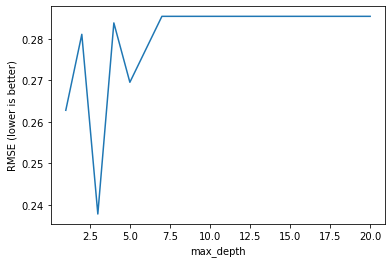

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [155]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=3, random_state=1)
classifier.fit(X_train_tree, y_train_tree)

from sklearn import metrics
y_pred_tree = classifier.predict(X_test_tree)

print("Decision Tree Accuracy:", metrics.accuracy_score(y_test_tree, y_pred_tree))

Decision Tree Accuracy: 0.875


In [156]:
target = ['Eliminated','Winner']
# Create a Graphviz file.
from sklearn.tree import export_graphviz
export_graphviz(classifier, out_file='tree_hits.dot', feature_names=feature_cols, class_names=target)
# At the command line, run this to convert to PNG:
#   dot -Tpng tree_hits.dot -o tree_hits.png

In [157]:
# Compute feature importances.
pd.DataFrame({'feature':feature_cols, 'importance':classifier.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
7,PERC_POINTS_APP,0.770901
2,PERC_WIN_APP,0.208559
3,PERC_HIGH_APP,0.020540
0,AGE,0.000000
1,EP.3,0.000000
4,PERC_SAFE_APP,0.000000
5,PERC_LOW_APP,0.000000
6,PERC_BTM_APP,0.000000
8,MAKEOVER_RANK,0.000000
9,SEASON,0.000000
